In [18]:
#Source : 파이썬을 활용한 금융공학 레시피 by 김용환, 일부 수정
import pandas as pd
import datetime as dt
import bs4
from urllib.request import urlopen
import matplotlib.pyplot as plt
%matplotlib inline


def date_format(d):
    d = str(d).replace('-', '.')
    yyyy=int(d.split('.')[0])
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return this_date


def historical_index_naver_date(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    if start_date:
        start_date=date_format(start_date)
    else: 
        start_date = dt.date.today()
    if end_date : 
        end_date=date_format(end_date)
    else:
            end_date=dt.date.today()
    
    naver_index = 'https://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n) 
    source = urlopen(naver_index).read()
    source = bs4.BeautifulSoup(source, 'lxml') 
    
    dates=source.find_all('td',class_='date') #<td class ="date">
    prices=source.find_all('td', class_='number_1') #<td class = "number_1">
    
    for n in range(len(dates)): 
        if dates[n].text.split('.')[0].isdigit():
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                this_close=prices[n*4+1].text
                this_close=this_close.replace('%', '') 
                this_close=float(this_close)
                
                trade_volume = prices[n*4+3].text
                trade_volume = trade_volume.replace(',','')
                trade_volume = float(trade_volume)
    
                historical_prices_date[this_date] = this_close
                historical_volume_date[this_date] = trade_volume
            
            elif this_date < start_date:
                return historical_prices_date, historical_volume_date
    
    if last_page ==0:
        last_page = source.find('td',class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    if page_n < last_page:
        page_n = page_n +1
        historical_index_naver_date(index_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices_date, historical_volume_date

historical_prices_date = dict()
historical_volume_date = dict()
historical_prices_date, historical_volume_date = historical_index_naver_date('KOSPI', '2010.08.10', '2020.08.10')

Text(0, 0.5, 'Trade Volume rate')

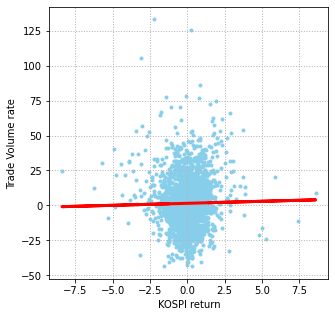

In [20]:
tmp = {
    'KOSPI return' : historical_prices_date,
    'Trade Volume' : historical_volume_date
}

df = pd.DataFrame(tmp)
df.sort_index(axis=0,inplace=True)
df['Trade Volume rate'] = df['Trade Volume'].pct_change() * 100
df = df.drop(pd.to_datetime('2010-08-10'))

import numpy as np 
from sklearn.linear_model import LinearRegression
x = df['KOSPI return']
y = df['Trade Volume rate']

independent_var = np.array(x).reshape(-1,1)
dependent_var = np.array(y).reshape(-1,1)

#Linear Regression
regr = LinearRegression()
regr.fit(independent_var, dependent_var)

result = {'Slope': regr.coef_[0,0], 'Intercept':regr.intercept_[0], 'R2':regr.score(independent_var, dependent_var)}

plt.figure(figsize=(5,5))
plt.scatter(independent_var, dependent_var, marker='.', color = 'skyblue')
plt.plot(independent_var, regr.predict(independent_var), color ='r', linewidth =3)
plt.grid(True, color = '0.7', linestyle=':', linewidth=1)
plt.xlabel('KOSPI return')
plt.ylabel('Trade Volume rate')

In [ ]:
# As shown, No significant relation between Kospi return and Trade volume(value) growth